In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.integrate as spint
import scipy.interpolate as spinterp
import lmfit
from lmfit import Minimizer, Parameters, report_fit
'''Karan Kumar 14906619'''

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
test = stars[stars['Name'] == 'HSC_38']
test

,Name,ID,GaiaDR3,inrt,Prob,RAdeg,e_RAdeg,DEdeg,e_DEdeg,GLON,...,o_RVd,GRVSmag,e_GRVSmag,o_GRVSmag,Vbroad,e_Vbroad,o_Vbroad,VarFlag,NSS,RVS
271954,HSC_38,1835,4063634658072393984,0,1.000000,269.480534,0.070968,-26.907709,0.059625,3.131261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
271955,HSC_38,1835,4063634658085846656,0,0.943917,269.483533,0.068428,-26.899140,0.058114,3.140022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
271956,HSC_38,1835,4063634726805334656,1,0.934357,269.446852,0.086676,-26.917035,0.071000,3.108160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
271957,HSC_38,1835,4063634829884563968,0,0.992583,269.458755,0.065672,-26.893702,0.053637,3.133681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
271958,HSC_38,1835,4063634898590736128,0,0.986327,269.476743,0.370175,-26.878863,0.281034,3.154558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272528,HSC_38,1835,4063626544824264448,1,0.931052,269.307878,0.036860,-27.036679,0.029980,2.942546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
272529,HSC_38,1835,4063626514826891264,1,1.000000,269.325307,0.043212,-27.028509,0.035317,2.957399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
272530,HSC_38,1835,4063626922784970624,1,0.954819,269.287494,0.144384,-27.022264,0.119553,2.945922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0
272531,HSC_38,1835,4063626927143789952,1,0.943698,269.282580,0.121411,-27.031187,0.099390,2.936004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NOT_AVAILABLE,0,0


In [4]:
my_clusters = ['HSC_38', 'Tombaugh_1', 'Gaia_1'] #my assigned clusters

assigned_df = stars[stars['Name'].isin(my_clusters)].copy()

In [5]:
assigned_df['Name'].unique() # i guess it finds the clusters alphabetically
HSC_38 = stars[stars["Name"].isin(["HSC_38"])].copy()
Tombaugh_1 = stars[stars["Name"].isin(["Tombaugh_1"])].copy()
Gaia_1= stars[stars["Name"].isin(["Gaia_1"])].copy()

In [6]:
def radial(df_cluster):
    '''I copied alot of what i did in my assignment 2 per_cluster() function for this
    Calculate the radial seperation between a star and it's cluster postions in RA and DEC
    Calculate the radial seperation between a star and mean position of a cluster
    
    input-
    df_cluster- dataframe of the cluster you want to analyze
    variables:
    radial- the radial speration, as a magnitude'''
    #calculate the means in this order of one cluster
    clusters = df_cluster.copy()
    RA_mean = clusters['RAdeg'].mean()
    DE_mean = clusters['DEdeg'].mean()
    #calculate the radial seperation
    radial = 3600*np.sqrt((np.power(clusters['RAdeg'] - RA_mean,2) + np.power(clusters['DEdeg'] - DE_mean,2)))
    radial_err = 3600*np.sqrt((np.power(clusters['e_RAdeg'] - RA_mean,2) + np.power(clusters['e_DEdeg'] - DE_mean,2)))
    clusters['Radial'] = radial
    clusters['Radial_err'] = radial_err
    return clusters
Gaia_1 =  radial(Gaia_1)
HSC_38  = radial(HSC_38)
Tombaugh_1 = radial(Tombaugh_1)


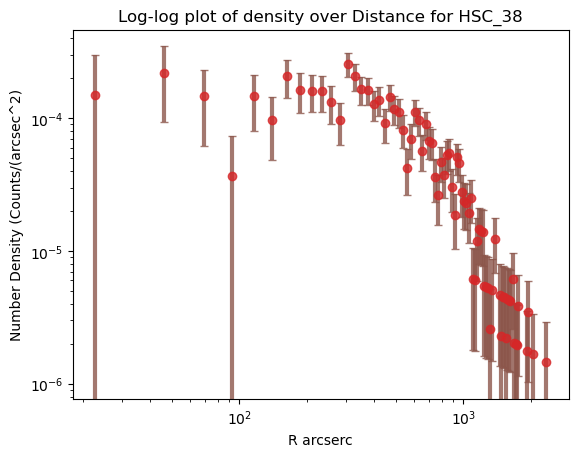

In [7]:
def density_profile(df_cluster,bin_num,color):
    '''This follows my solution from the programming for astronomy course
    compute the area of an annulus using bin edeges as the radius
    return area: the area of each bin'''
    #for plotting
    cluster_name = df_cluster['Name'].unique()[0]
    r_centriod = df_cluster['Radial']
    #r_histo counts of stars in a bin 
    #r_bins number of bins
    r_histo, r_bins = np.histogram(r_centriod,bins=bin_num)
    r_err, r_err_bins = np.histogram(df_cluster['Radial_err'], bins=bin_num)
    N = len(r_bins)
    bin_area = []
    for i in range(N-1):
        a  = 2*np.pi*(r_bins[i+1]**2 - r_bins[i]**2) # area of annulus
        bin_area.append(a)
    #go around the center of the bin or center of annalus
    r_bin_center = (r_bins[:-1] + r_bins[1:]) / 2
    #number of stars per bin
    rho = r_histo/bin_area
    #check this later- should i have used real data for this
    rho_err = np.sqrt(r_histo)/bin_area
    plt.errorbar(r_bin_center, rho, yerr=rho_err,color=color,ecolor='tab:brown',fmt='o',elinewidth=3,capsize=3,alpha=0.8)
    plt.xlabel('R arcserc')
    plt.ylabel('Number Density (Counts/(arcsec^2)')
    plt.xscale('log')
    plt.title('Log-log plot of density over Distance for '+ cluster_name)
    plt.yscale('log')
    plt.show()
    return r_bin_center, rho, rho_err
plot_HSC = density_profile(HSC_38,100,'tab:red') 

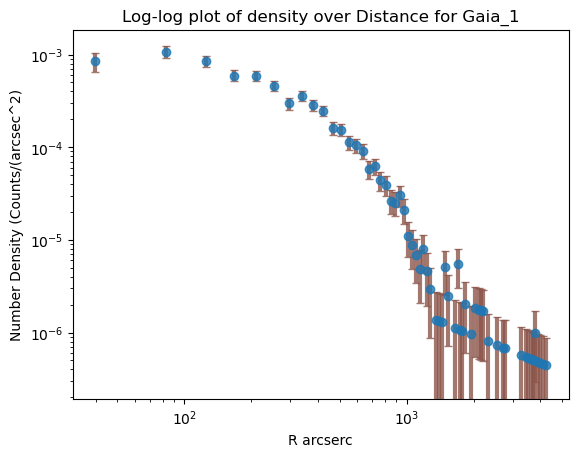

In [8]:
plot_Gaia = density_profile(Gaia_1, 100,'tab:blue')

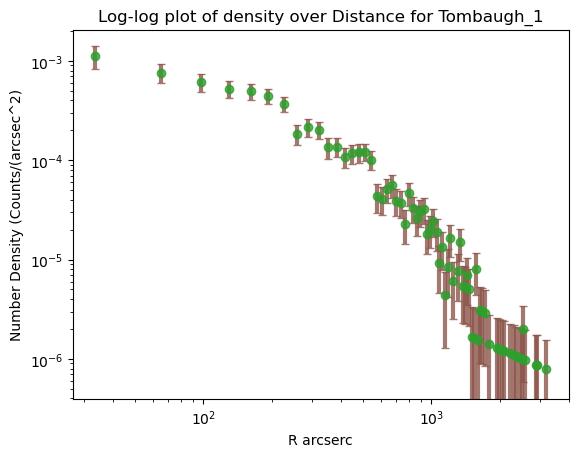

In [69]:
plot_Tombaugh = density_profile(Tombaugh_1, 100,'tab:green')

# Q2

In [10]:
params = Parameters()  # Assigns a variable name to an empty Parameters object
params.add_many(('rho',10),('rc',30),('rt',130),('C',150))  # Adds multiple parameters, specifying the name and starting value
x = params.valuesdict()

In [102]:
def king_model(r_val,params):
    #initalize y as an array
    #create a parameter dictionary
    x = params.valuesdict()

    y = np.ones(len(r_val)) * x['rt']
    frac1 = 1/np.sqrt(1 + (r_val/x['rc']))**2
    frac2 = 1/np.sqrt(1 + (x['rt']/x['rc']))**2
    frac = frac1 - frac2
    y =  x['rho']*frac + x['C']
    #replace all values of large r with r_t
    y[(r_val > x['rt'])] = x['C']
    return y


# This is copied directly from Phils Episode 9
## I should explain what it does

In [12]:

def lmf_lsq_resid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1, n2 respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model(xdata[i],params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model(xdata[i],params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model(xdata[i],params))
        return ymodel


In [85]:
def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        ymod[i], ymoderr = spint.quad(lambda x: model(x, params),xbins[i],xbins[i+1])
        ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
    return ymod

def lmf_lsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

In [55]:
def grid1d_chisqmin(a_name,a_range,a_steps,parm,model,xdata,ydata,yerrs):
    '''Uses lmfit. Finds best the fit and then carries out chisq minimisation for a 1D grid of fixed 
       parameters.
       Input: 
            a_name - string, name of 'a' parameter (in input Parameters object parm) to use for grid.
            a_range, a_steps - range (tuple or list) and number of steps for grid.
            parm - lmfit Parameters object for model to be fitted.
            model - name of model function to be fitted.
            xdata, ydata, yerrs - lists of data x, y and y-error arrays (as for the lmf_lsq_resid function)
        Output: 
            a_best - best-fitting value for 'a'
            minchisq - minimum chi-squared (for a_best)
            a_grid - grid of 'a' values used to obtain fits
            chisq_grid - grid of chi-squared values corresponding to a_grid'''
    a_grid = np.linspace(a_range[0],a_range[1],a_steps)
    chisq_grid = np.zeros(len(a_grid))
    # First obtain best-fitting value for 'a' and corresponding chi-squared
    set_function = Minimizer(lmf_lsq_resid, parm, fcn_args=(xdata, ydata, yerrs, model, True),
                             nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    minchisq = result.chisqr
    a_best = result.params.valuesdict()[a_name]
    # Now fit for each 'a' in the grid, to do so we use the .add() method for the Parameters object
    # to replace the value of a_name with the value for the grid, setting vary=False to freeze it
    # so it cannot vary in the fit (only the other parameters will be left to vary)
    for i, a_val in enumerate(a_grid):
        parm.add(a_name,value=a_val,vary=False)
        set_function = Minimizer(lmf_lsq_resid, parm, fcn_args=(xdata, ydata, yerrs, model, True), 
                                                                nan_policy='omit')
        result = set_function.minimize(method = 'leastsq')
        chisq_grid[i] = result.chisqr
    return a_best, minchisq, a_grid, chisq_grid 

def calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid):
    '''Function to return upper and lower values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_best, minchisq - best-fitting value for 'a' and corresponding chi-squared minimum
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid[a_grid > a_best],a_grid[a_grid > a_best])
    a_upper = chisq_interp_upper(minchisq+delchisq)
    # Interpolate for values <= a_best to find lower interval bound
    chisq_interp_lower = spinterp.interp1d(chisq_grid[a_grid <= a_best],a_grid[a_grid <= a_best])
    a_lower = chisq_interp_lower(minchisq+delchisq)  
    return [a_lower,a_upper]

In [141]:
def make_lmf_stuff(dataset,clustername,color,param_guess,confident,delchiflt):
    '''Do lmf stuff
    dataset- nested list of x values, y values, y_err vales indexed in that order
    clustername- str for plotting cluster name
    color- str for plotting
    param_guess- lst inital parameter guess in order, rho, rc, rt, C guesses should be floats or int
    confident - Boolean - only run confidence interval if this is True else dont
    delchiflt, float of sigma confidence interval'''
    
    params = Parameters()  # Assigns a variable name to an empty Parameters object
    params.add_many(('rho',param_guess[0]),('rc',param_guess[1]),('rt',param_guess[2]),('C',param_guess[3]))  # Adds multiple parameters, specifying the name and starting value
    x = params.valuesdict()
    model = king_model
    output_resid = True

    #for some reason this HAS to be a nested list
    xdata = [dataset[0]]
    ydata = [dataset[1]]
    yerrs = [dataset[2]]
    set_function = Minimizer(lmf_lsq_resid, params, fcn_args=(xdata, ydata, yerrs, model, output_resid), nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    print("Model fit for " +clustername)
    report_fit(result)

    #confidence interval stuff using lmfit
    
    #make a model sample
    model_ens = np.linspace(np.min(xdata), np.max(xdata),1000)
    
    # To calculate the best-fitting model values, use the parameters of the best fit output
    # from the fit, result.params and set output_resid=false to output a list of model y-values:
    model_vals = lmf_lsq_resid(result.params,[model_ens],ydata,yerrs,model,output_resid=False)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.suptitle("Kind Model fit for "+clustername)
    fig.subplots_adjust(hspace=0)
    ax1.scatter(dataset[0], dataset[1],alpha = 0.5, color=color, label='Data')
    #ax1.errorbar(dataset[0], dataset[1],yerr=dataset[2], marker="o", linestyle="--",label='Data',color=color,ecolor='tab:brown')
    ax1.plot(model_ens, model_vals[0], lw=2,color='tab:purple',label='Model')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.set_yscale('log')
    ax2.errorbar(dataset[0],
             dataset[1]-lmf_lsq_resid(result.params,xdata,ydata,yerrs,model,output_resid=False)[0],
             yerr=dataset[2],marker="o", linestyle="",color=color, ecolor ='tab:brown')

    
    #add labels
    ax1.set_ylabel('Number Density Counts/arcsec^2')
    ax2.set_ylabel("Residuals Counts/arcsec^2")
    ax2.set_xlabel('R arcsec')
    # if confident: 
    #     confid = lmfit.conf_interval(set_function,result)#dictionary
    #     confid_val = confid['rt']
    #     #list arguements are low and upper limit of interval
    #     one_sigma = [confid_val[0][1], confid_val[-1][1]]
    #     ax1.vlines(one_sigma,ymin=0,ymax=np.max(dataset[1]),color='k',linestyle='dashed', label= r" 1$\sigma$ confidence")
    fig.legend()
    plt.show()

    par_names = ['rc','rt'] # Names of parameters in Parameters object
    n_steps = 1000  # Number of steps in our grids
    # Ranges for each parameter - should aim for a few times times 1-sigma error estimated from covariance
    # We can specify by hand or use the values from the original minimize result if available:
    par_ranges = []
    for i, par_name in enumerate(par_names):
        # range min/max are best-fitting value -/+ four times the estimated 1-sigma error from variances 
        # (diagonals of covariance matrix)
        par_min = result.params.valuesdict()[par_name] - 10*np.sqrt(result.covar[i,i])
        par_max = result.params.valuesdict()[par_name] + 10*np.sqrt(result.covar[i,i])
        par_ranges.append([par_min,par_max])
    #par_ranges = [[109,112],[175,177],[204,206]]   # if specified by hand
    print("Parameter ranges for grid:",par_ranges)
    # For convenience when plotting we will store our results in arrays, which we now set up:
    a_best = np.zeros(len(par_ranges))
    minchisq = np.zeros(len(par_ranges))
    a_grid = np.zeros((len(par_ranges),n_steps))
    chisq_grid = np.zeros((len(par_ranges),n_steps))
    a_int = np.zeros((len(par_ranges),2))
    delchisq = delchiflt  # For 1-sigma errors for a single parameter 
    
    # Now do the grid calculation for each parameter:
    for i, par_range in enumerate(par_ranges):
        params2 = Parameters()
        params2.add_many(('rc',param_guess[1]),('rt',param_guess[2]))#('rt',param_guess[2]),('C',param_guess[3]))
        a_best[i], minchisq[i], a_grid[i,:], chisq_grid[i,:] = grid1d_chisqmin(par_names[i],par_range,n_steps,params,model,
                                 xdata,ydata,yerrs)
        #a_int[i,:] = calc_error_chisq(delchisq,a_best[i],minchisq[i],a_grid[i,:],chisq_grid[i,:])
        # Good presentation of results should round off MLE and errors to an appropriate number
        # of decimal places. Here we choose 3 to demonstrate the symmetry of the errors, we 
        # could have used 2 decimal places since that is consistent with the size of the error bars
        print('MLE '+par_names[i]+':',str(np.round(a_best[i],3)),
              'with errors:',str(np.round((a_int[i,:]-a_best[i]),3)))
    
    #Now plot along with a cross to mark the MLE and dotted lines to show the 1-sigma intervals
    par_xlabels = [r'$r_{c}$',r'$r_{t}$']
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3), sharey=True)
    fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.1, hspace=None)
    for i, ax in enumerate([ax1, ax2]):
        ax.plot(a_grid[i,:],chisq_grid[i,:],color=color)
        ax.scatter(a_best[i],minchisq[i],marker='+',color=color)
        ax.vlines(a_int[i,:],ymin=30,ymax=100,color='gray',linestyle='dotted')
        ax.set_xlabel(par_xlabels[i],fontsize=12)
    ax1.set_ylabel(r'$\chi^{2}$',fontsize=12)
    ax1.set_ylim(30,70)
    #plt.figure()
    #plt.plot(a_grid[0], chisq_grid[0])
    plt.show()
    return None

Model fit for HSC_38
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 75
    # variables        = 4
    chi-square         = 86.5152621
    reduced chi-square = 1.21852482
    Akaike info crit   = 18.7124544
    Bayesian info crit = 27.9824068
[[Variables]]
    rho:  4.1434e-04 +/- 9.3102e-05 (22.47%) (init = 10)
    rc:   1536.91265 +/- 957.998748 (62.33%) (init = 30)
    rt:   1243.93828 +/- 32.0511070 (2.58%) (init = 130)
    C:    2.8318e-06 +/- 5.7359e-07 (20.26%) (init = 150)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, rc) = +0.9497
    C(rho, rt) = -0.6817
    C(rc, rt)  = -0.5494
    C(rt, C)   = -0.2173


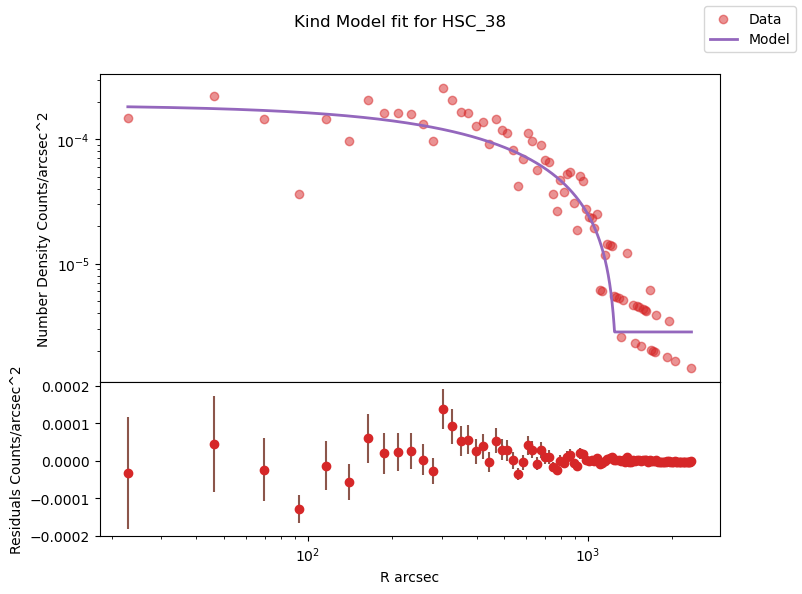

Parameter ranges for grid: [[1536.911723634657, 1536.9135856844964], [-8336.049199482199, 10823.925765525846]]
MLE rc: 1536.913 with errors: [-1536.913 -1536.913]
MLE rt: 1234.116 with errors: [-1234.116 -1234.116]


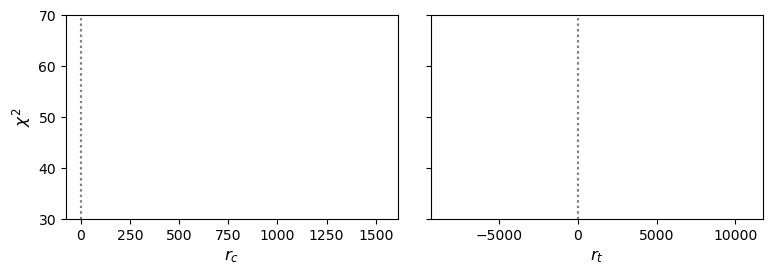

In [140]:
HSC_guess = [10,30,130,150] #old guess before confidience interval [10, 30,130,150]
HSC_fit = make_lmf_stuff(plot_HSC,"HSC_38",'tab:red',HSC_guess,confident=False,delchiflt=3.0)

Model fit for GAIA_1
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 60
    # variables        = 4
    chi-square         = 63.2307414
    reduced chi-square = 1.12912038
    Akaike info crit   = 11.1467621
    Bayesian info crit = 19.5241403
[[Variables]]
    rho:  0.00224431 +/- 4.2452e-04 (18.92%) (init = 0.001)
    rc:   78.7011142 +/- 21.2552572 (27.01%) (init = 70)
    rt:   1079.98207 +/- 21.0191145 (1.95%) (init = 1000)
    C:    7.4982e-07 +/- 1.3741e-07 (18.33%) (init = 1e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, rc) = -0.9728
    C(rc, rt)  = -0.3901
    C(rho, rt) = +0.2692


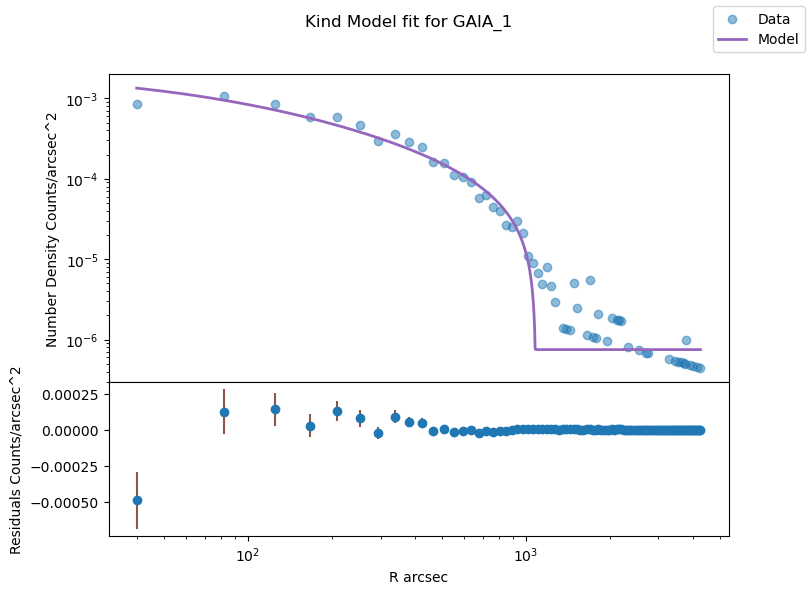

Parameter ranges for grid: [[78.69686905901953, 78.70535941144037], [867.4294983804496, 1292.534641617123]]
MLE rc: 78.701 with errors: [-78.701 -78.701]
MLE rt: 1079.98 with errors: [-1079.98 -1079.98]


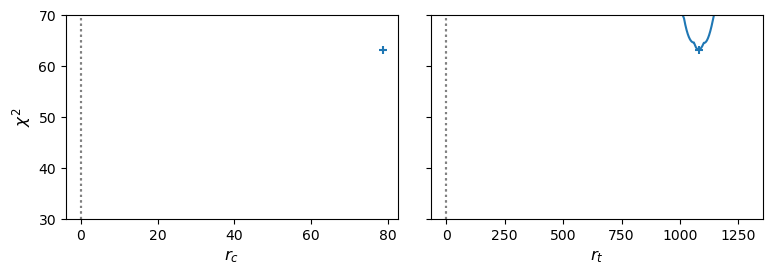

In [142]:
Gaia_guess = [0.001,70,1000,1e-06]
Gaia_fit = make_lmf_stuff(plot_Gaia, 'GAIA_1','tab:blue',Gaia_guess,confident=True,delchiflt=1.0)

Model fit for Tombaugh_1
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 60
    # variables        = 4
    chi-square         = 64.4444171
    reduced chi-square = 1.15079316
    Akaike info crit   = 12.2875124
    Bayesian info crit = 20.6648907
[[Variables]]
    rho:  0.00216728 +/- 3.9950e-04 (18.43%) (init = 1)
    rc:   86.1135197 +/- 23.7095074 (27.53%) (init = 200)
    rt:   1055.04537 +/- 24.1258298 (2.29%) (init = 500)
    C:    7.5846e-07 +/- 1.3865e-07 (18.28%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho, rc) = -0.9686
    C(rc, rt)  = -0.4393
    C(rho, rt) = +0.3003


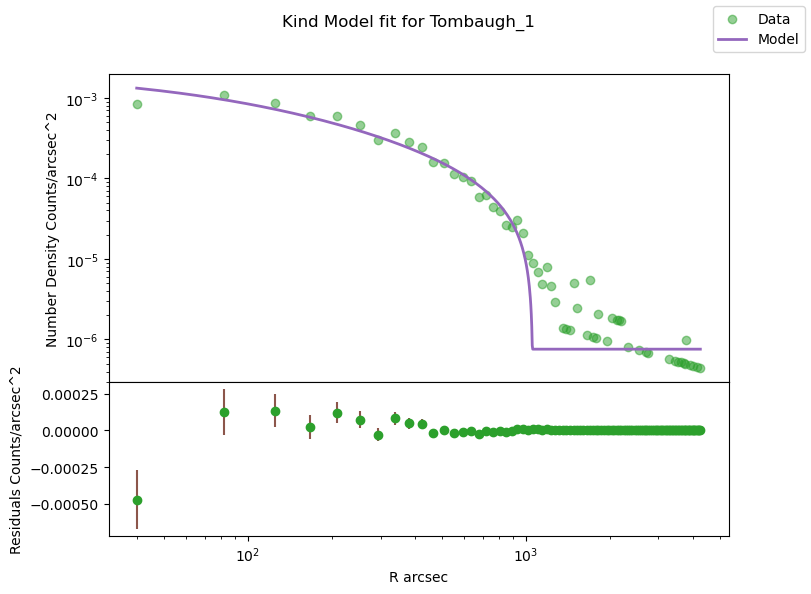

Parameter ranges for grid: [[86.11112268434842, 86.11591673898646], [912.7883262893357, 1197.3024149556309]]
MLE rc: 86.114 with errors: [-86.114 -86.114]
MLE rt: 1055.044 with errors: [-1055.044 -1055.044]


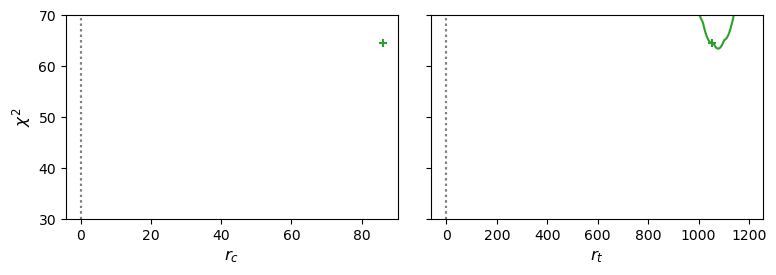

<Figure size 640x480 with 0 Axes>

In [130]:
Tombaugh_guess = [1, 200, 500, 1]
Tombaugh_fit = make_lmf_stuff(plot_Gaia, 'Tombaugh_1','tab:green',Tombaugh_guess,confident=True,delchiflt=1.0)

In [ ]:
Gaia_1.columns

In [110]:
def another_density_profile(df_cluster,bin_num):
    '''This follows my solution from the programming for astronomy course
    compute the area of an annulus using bin edeges as the radius
    return area: the area of each bin
    same as old one only without plotting'''
    #for plotting
    cluster_name = df_cluster['Name'].unique()[0]
    r_centriod = df_cluster['Radial']
    #r_histo counts of stars in a bin 
    #r_bins number of bins
    r_histo, r_bins = np.histogram(r_centriod,bins=bin_num)
    r_err, r_err_bins = np.histogram(df_cluster['Radial_err'], bins=bin_num)
    N = len(r_bins)
    bin_area = []
    for i in range(N-1):
        a  = 2*np.pi*(r_bins[i+1]**2 - r_bins[i]**2) # area of annulus
        bin_area.append(a)
    #go around the center of the bin or center of annalus
    r_bin_center = (r_bins[:-1] + r_bins[1:]) / 2
    #number of stars per bin
    rho = r_histo/bin_area
    #check this later- should i have used real data for this
    rho_err = np.sqrt(r_histo)/bin_area
    return r_bin_center,rho,rho_err

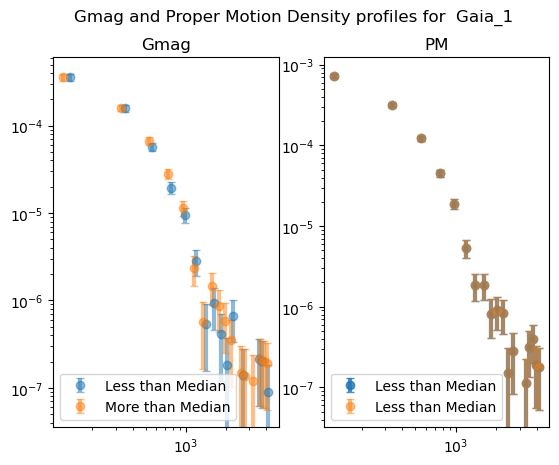

In [123]:
def subsample(df_cluster):
    '''Split a cluster into two subsamples, by Gmag and mean proper motion'''
    #columns Gmag and Mean PM, create the Mean PM
    cluster_name = df_cluster['Name'].unique()[0]
    copy_dataframe = df_cluster.copy()
    #calculate the mean PM
    proper_motion_mag = (df_cluster['pmRA'].mean())**2 + (df_cluster['pmDE'].mean())**2
    proper_motion_mag = np.sqrt(proper_motion_mag)
    copy_dataframe["PM" ] = proper_motion_mag

    PM_median = copy_dataframe['PM'].median()
    Gmag_median = copy_dataframe['Gmag'].median()

    PM_below_median = copy_dataframe[copy_dataframe['PM'] <= PM_median]
    PM_after_median = copy_dataframe[copy_dataframe['PM'] >= PM_median]

    G_below_median = copy_dataframe[copy_dataframe['Gmag'] <= Gmag_median]
    G_after_median = copy_dataframe[copy_dataframe['Gmag'] >= Gmag_median]
    bin_num = 20
    # argurements = df_cluster, bin_num, color
    PMbelow_den = another_density_profile(PM_below_median, bin_num)
    PMafter_den = another_density_profile(PM_after_median, bin_num)
    Gbelow_den = another_density_profile(G_below_median, bin_num)
    Gafter_den = another_density_profile(G_after_median, bin_num)
    
    #plotting
    fig, axs = plt.subplots(1, 2)
     #plt.errorbar(r_bin_center, rho, yerr=rho_err,color=color,ecolor='tab:brown',fmt='o',elinewidth=3,capsize=3,alpha=0.8)
    fig.suptitle('Gmag and Proper Motion Density profiles for  '+cluster_name)
   # axs[0].set_title['Gmag']
    axs[0].set_title("Gmag")
    axs[1].set_title("PM")
    axs[0].errorbar(Gbelow_den[0], Gbelow_den[1], yerr=Gbelow_den[2], color='tab:blue',fmt='o',elinewidth=3,capsize=3,alpha=0.5, label='Less than Median')
    axs[0].errorbar(Gafter_den[0], Gafter_den[1], yerr=Gafter_den[2], color='tab:orange',fmt='o',elinewidth=3,capsize=3,alpha=0.5, label='More than Median')
    axs[0].legend()
    axs[1].errorbar(PMbelow_den[0], PMbelow_den[1], yerr=PMbelow_den[2], color='tab:blue',fmt='o',elinewidth=3,capsize=3,alpha=0.8, label='Less than Median')
    axs[1].errorbar(PMafter_den[0], PMafter_den[1], yerr=PMafter_den[2], color='tab:orange',fmt='o',elinewidth=3,capsize=3,alpha=0.5, label='Less than Median')
    axs[1].legend()
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    plt.show()
    
    return None
Gaia_samp = subsample(Gaia_1)